# Monte Carlo Portfolio Optimizer

This project explores portfolio construction using classical mean–variance optimization (MVO) and a Monte Carlo (MC) resampling procedure. The study is divided into two parts. The first examines a portfolio of broad market indexes and bonds, showing how the MC approach assigns greater value to stable assets that trade returns for lower volatility. The second part focuses on diversification in portfolios of individual stocks across stable and unstable market periods and highlights the inherent fragility of both MVO and MC when markets become turbulent.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import utils

import warnings
warnings.simplefilter("ignore", category = FutureWarning)

In [2]:
r = utils.get_r()
print(f"Risk-free interest rate: {r}")

Risk-free interest rate: 0.0001422706468645618


## Monte Carlo Trades Returns for Robustness

We start by constructing a four-asset portfolio with three major ETFs (SPY, XLV, XLF) and the bond market ETF BND, which serves as a stabilizing asset. We extract historical prices from Yahoo Finance over the bullish 2013–2019 period and split them into two parts: 2013–2017 data is used to fit the MVO and MC portfolios, while 2018–2019 data provides an out-of-sample test of their performance.

In [3]:
tickers = ["SPY", "XLV", "XLF", "BND"]
df = utils.get_returns(tickers, start = "2013-01-01", end = "2017-12-31")
df_test = utils.get_returns(tickers, start = "2018-01-01", end = "2019-12-31")

With the historical data extracted, we estimate the average daily returns and the covariance matrix for all tickers.

In [4]:
mu, sigma = utils.parameters(df)

We then apply MVO to construct portfolio weights that maximize the Sharpe ratio.

In [5]:
w = utils.optimize_weights(mu, sigma, objective = "max_sharpe", r = r)

The pure MVO gives a single portfolio by using historical estimates of expected returns and covariances directly. However, these estimates are noisy, which makes the optimized weights unstable. This instability can be reduced by using a Monte Carlo resampling procedure: the data is resampled many times, parameters are re-estimated, and the optimization is repeated. By aggregating the resulting weight vectors (e.g. taking the median), we obtain a portfolio that is more robust to estimation error. This Monte Carlo portfolio typically diverges somewhat from the straight MVO solution, but the difference reflects a reduction in sensitivity to noise rather than a failure of optimization.

In [6]:
W_mc, w_mc = utils.monte_carlo(df, iterations = 50000, objective = "max_sharpe")

Monte Carlo: 100%|██████████| 50000/50000 [01:36<00:00, 516.37it/s]


We can now plot a comparison between the weights from the pure MVO solution and those from the Monte Carlo median. This shows that applying the Monte Carlo approach leads to a redistribution of weights across the assets.

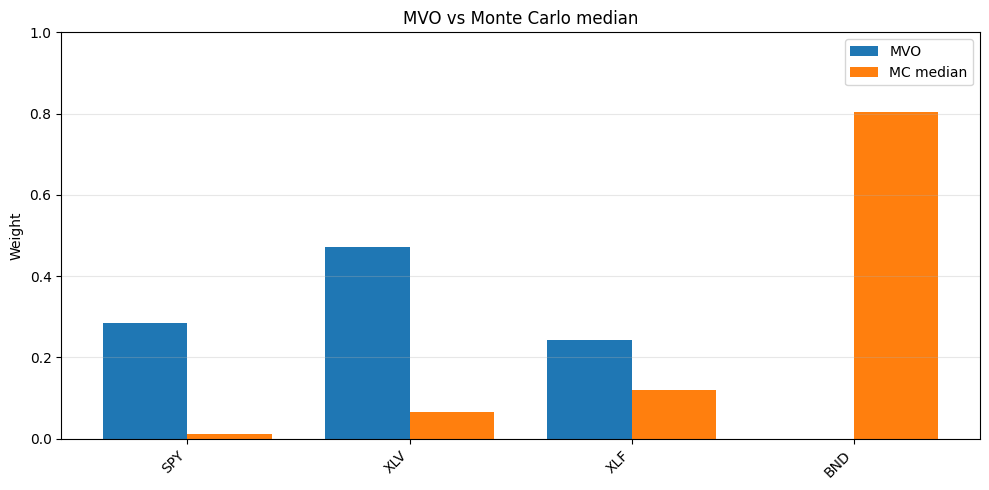

In [7]:
utils.plot_weights(w, w_mc)

When comparing the two solutions, we see that MVO allocates heavily to equities (SPY, XLV, XLF), while completely excluding bonds (BND). In contrast, the Monte Carlo median shifts the portfolio almost entirely toward BND, with only small residual allocations to equities. This happens because resampling penalizes the instability of equity allocations and favors bonds as a consistent source of risk reduction.

It is also important to assess how stable the Monte Carlo allocation is when the sample period shifts. This can be examined using the confidence bands: for each asset, the vertical bar shows the range between the lower and upper percentiles, while the point marks the median allocation. The MVO weights are included as crosses for direct comparison. As seen here, these allocations are fairly stable, with average band width being close to 30%:

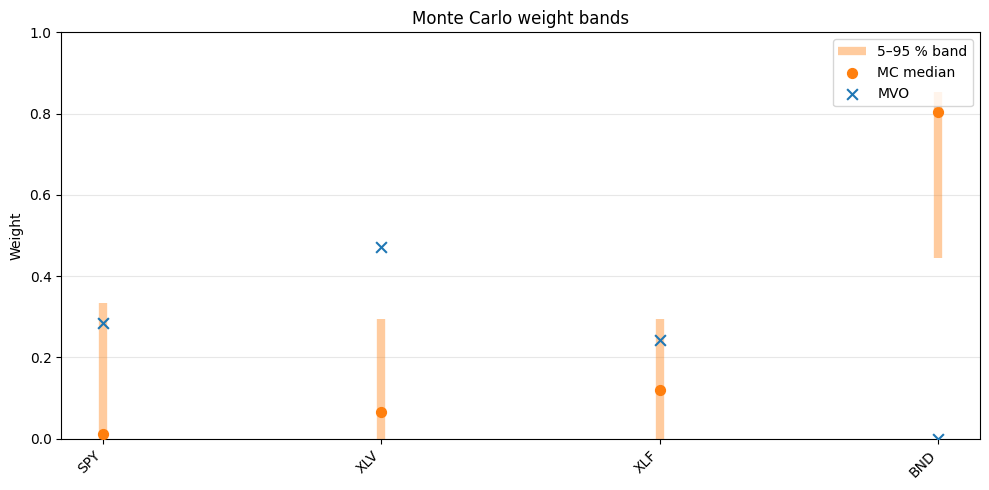

In [8]:
utils.plot_weight_bands(W_mc, w)

While the MVO portfolio is mathematically optimal given historical estimates of returns and covariances, those inputs are noisy and lead to fragile allocations. Monte Carlo resampling addresses this by repeatedly perturbing the data and re-optimizing, which produces a distribution of possible portfolios. The median allocation from this distribution is less extreme and more robust, which makes the Monte Carlo portfolio generally more reliable out-of-sample.

After optimizing the portfolio on the 2013–2017 data, we can test its performance on the out-of-sample period of 2018–2019. This allows us to evaluate how the MVO and MC approaches hold up when applied to new data rather than the sample on which they were fitted.

In [9]:
utils.test(df_test, w, w_mc, r = r)

,mean_ann,vol_ann,sharpe_ann
MVO,0.115425,0.148495,0.531500
MC,0.056382,0.031365,0.633879


MVO achieves a higher expected annual return but also carries substantially more volatility. Its Sharpe ratio is lower, indicating that the additional return does not compensate for the extra risk.

## Diversification during Market Instability

To better understand how Monte Carlo resampling changes portfolio allocations, it is useful to look at two contrasting market environments using the same set of assets. The portfolio of GLD (gold), AMZN, TSLA, and AAPL was chosen because it mixes high-growth, high-volatility equities with a traditional diversifier. The 2013–2018 period represents a long equity bull market, while 2019–2020 includes a turbulent episode marked by the COVID-19 crash and a sharp rally in gold. Comparing these two windows highlights how the optimizer reacts to different risk–return regimes.

In [22]:
tickers = ["GLD", "AMZN", "TSLA", "AAPL"]
df_stable = utils.get_returns(tickers, start = "2013-01-01", end = "2019-12-31")
df_unstab = utils.get_returns(tickers, start = "2020-01-01", end = "2020-12-31")

mu_stable, sigma_stable = utils.parameters(df_stable)
mu_unstab, sigma_unstab = utils.parameters(df_unstab)

w_stable = utils.optimize_weights(mu_stable, sigma_stable, objective = "max_sharpe", r = r)
w_unstab = utils.optimize_weights(mu_unstab, sigma_unstab, objective = "max_sharpe", r = r)

In [23]:
W_mc_stable, w_mc_stable = utils.monte_carlo(df_stable, iterations = 5000, objective = "max_sharpe")
W_mc_unstab, w_mc_unstab = utils.monte_carlo(df_unstab, iterations = 5000, objective = "max_sharpe")

Monte Carlo: 100%|██████████| 5000/5000 [00:09<00:00, 538.29it/s]


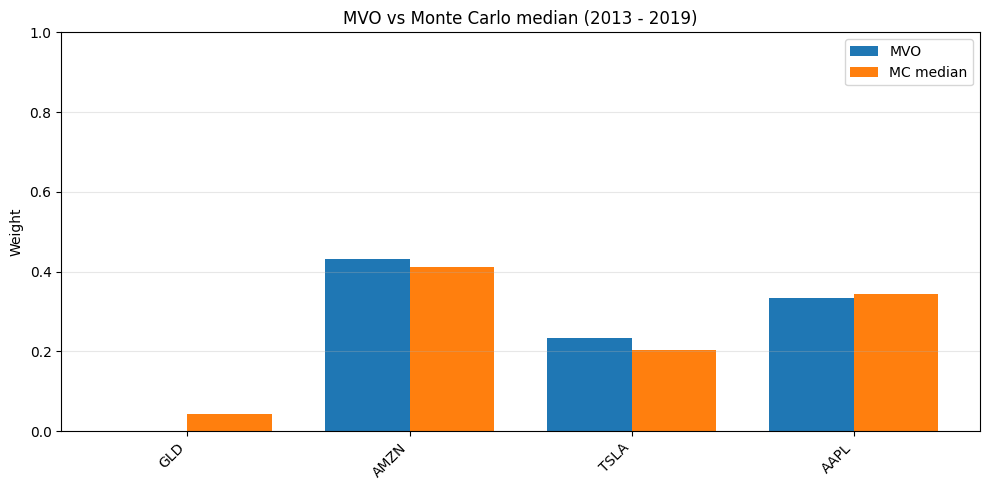

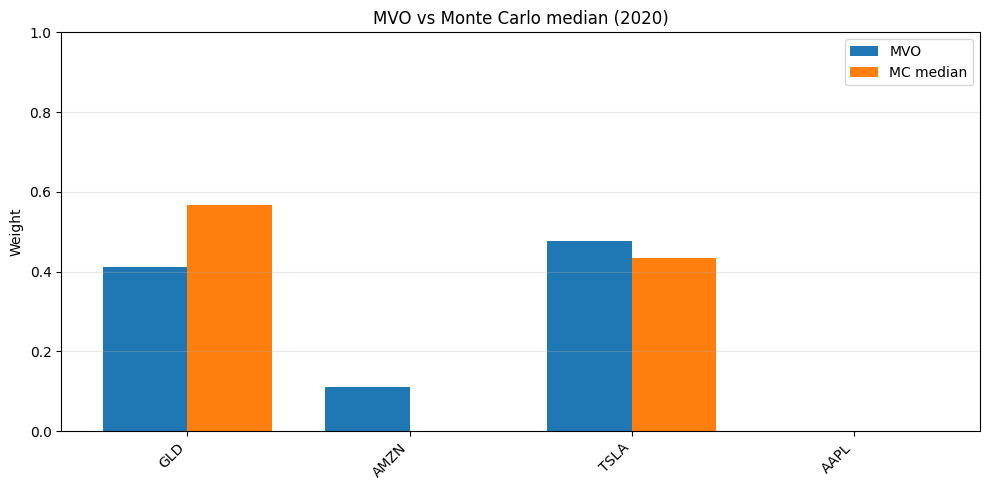

In [27]:
utils.plot_weights(w_stable, w_mc_stable, title = "MVO vs Monte Carlo median (2013 - 2019)")
utils.plot_weights(w_unstab, w_mc_unstab, title = "MVO vs Monte Carlo median (2020)")

In the stable period of 2013–2019, equities—particularly the large tech stocks—dominate the portfolio, with both MVO and MC producing relatively similar allocations. GLD receives essentially no weight, since diversification was not strongly rewarded during this calm market regime. In contrast, the unstable year 2020 shows a complete shift: GLD suddenly becomes a central allocation, with MC pushing its weight even higher than MVO. At the same time, the tech stocks as a group flip in importance, moving from being the primary drivers in the stable regime to being partially displaced by gold during the crisis.

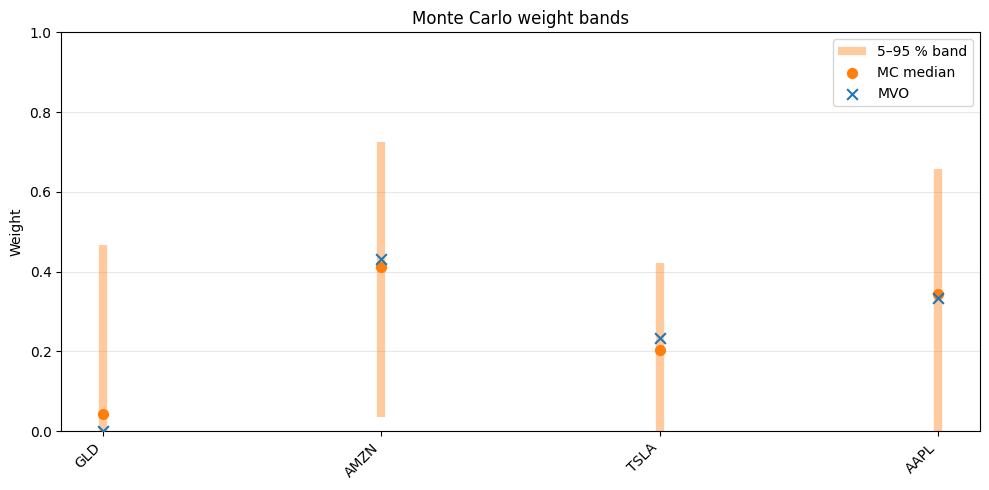

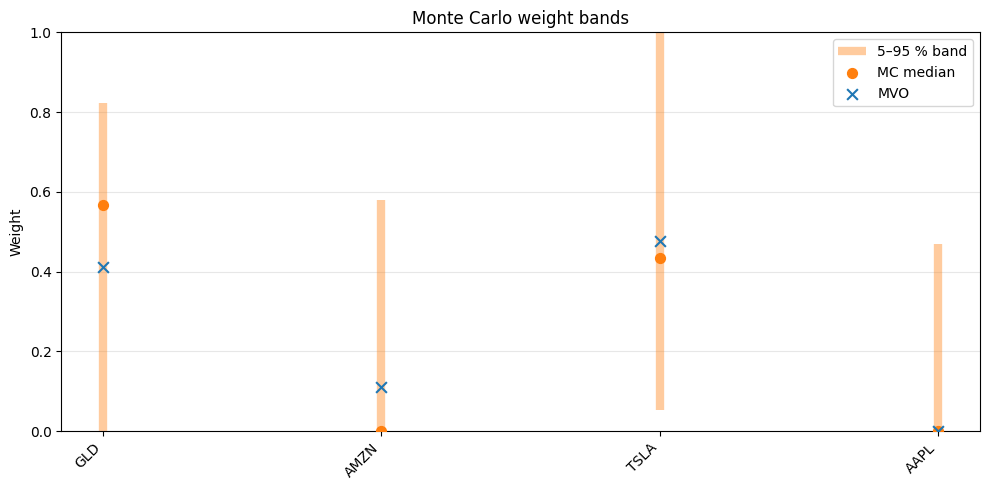

In [28]:
utils.plot_weight_bands(W_mc_stable, w_stable)
utils.plot_weight_bands(W_mc_unstab, w_unstab)

The highly unstable nature of the 2020 period results in confidence bands widening across the board, especially for GLD and the tech stocks such as TSLA. This indicates that the optimal allocation is much more sensitive to the specific return paths sampled, making the resulting portfolio highly unstable even after applying the Monte Carlo procedure.

## Conclusions

This project compared classical mean–variance optimization (MVO) with a Monte Carlo resampling approach. MVO directly uses historical estimates of returns and covariances, which makes it prone to instability. Monte Carlo resampling reduces this sensitivity by re-estimating parameters across many resampled datasets and aggregating the results. In stable periods, both methods yield similar allocations. In unstable periods, however, the Monte Carlo portfolios shift more weight toward stabilizing or diversifying assets, while MVO tends to over-concentrate in recent winners. The widening confidence bands in turbulent times highlight the increased uncertainty in portfolio construction. Overall, the Monte Carlo approach delivers more conservative but more robust allocations than pure MVO.